# Condensation Tutorial: Particle Resolved

*Work in progress, probably split into multiple notebooks, need to find a model system to test this on*

A particle resolved model is a model that tracks the properties of individual particles or collection of particles (e.g., super droplets). This is in contrast to a bulk model, which tracks the properties of the entire aerosol population. The particle resolved model can be more computationally expensive, but can provide more detailed information about the aerosol population.

To run this type of model we will need to use a speciated distribution representation. This is so that we can track the properties of individual particles.


In [106]:
import numpy as np
import matplotlib.pyplot as plt

# particula imports
from particula.next import particles
from particula.next.gas.atmosphere_builders import AtmosphereBuilder
from particula.next.gas.vapor_pressure_factories import VaporPressureFactory
from particula.next.gas.species_builders import GasSpeciesBuilder
from particula.next.aerosol import Aerosol
from particula.next.dynamics.particle_process import MassCondensation
from particula.next.dynamics.condensation.condensation_strategies import CondensationIsothermal

from particula.util.input_handling import convert_units

## Aerosol Object

First we'll draw from a lognormal distribution to create a set of particles. We'll will then build an aerosol object to represent the aerosol population.


In [107]:
# Ammonium sulfate and water vapor pressure
molar_mass_ammonium_sulfate = 132.14e-3  # kg/mol
molar_mass_water = 18.015e-3  # kg/mol
parameters_vapor = {
    "vapor_pressure": 1e-14,
}
vapor_pressure_ammonium = VaporPressureFactory().get_strategy(
    "constant", parameters_vapor
)
vapor_pressure_water = VaporPressureFactory().get_strategy(
    "water_buck"
)

water_sat = vapor_pressure_water.saturation_concentration(molar_mass=molar_mass_water, temperature=298.15)
water_concentration = water_sat * 1.04

gas_phase = (
    GasSpeciesBuilder()
    .set_molar_mass(np.array([molar_mass_water, molar_mass_ammonium_sulfate]), "kg/mol")
    .set_vapor_pressure_strategy([vapor_pressure_water, vapor_pressure_ammonium])
    .set_concentration(np.array([water_concentration, 1e-30]), "kg/m^3")
    .set_name(["H2O", "NH4HSO4"])
    .set_condensable([True, True])
    .build()
)

atmosphere = (
    AtmosphereBuilder()
    .add_species(gas_phase)
    .set_temperature(25, temperature_units="degC")
    .set_pressure(1, pressure_units="atm")
    .build()
)


## Sample Distribution

Next we'll sample the distribution to get a set of particles. We'll then build an aerosol object to represent the aerosol population.

Inital mass of particles: 4.3249677289319766e-12 kg
Initial mass concentration: 4.324967728931976e-06 kg/m^3
Gas mixture at 298.15 K and 101325.0 Pa consisting of ["['H2O', 'NH4HSO4']"]
[0]: Particle Representation:
	Strategy: ParticleResolvedSpeciatedMass
	Activity: ActivityKappaParameter
	Surface: SurfaceStrategyVolume
	Mass Concentration: 4.325e-06 [kg/m^3]
	Number Concentration: 1.000e+10 [#/m^3]


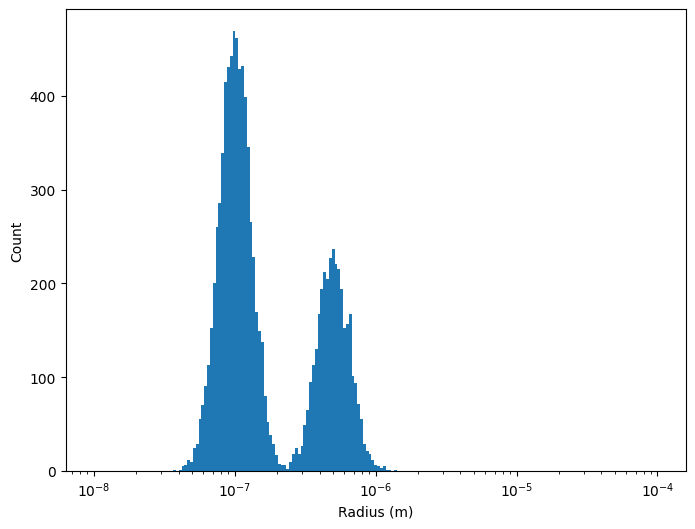

In [108]:
density = 1.77e3  # kg/m^3
volume_sim = 1  # cm^3

# Generate a particle distribution using a lognormal sample distribution
# This distribution has a mean particle diameter (mode) and geometric standard deviation (GSD)
particle_sample = particles.properties.lognormal_sample_distribution(
    mode=np.array([100, 500]) * 1e-9,
    geometric_standard_deviation=np.array([1.3, 1.3]),
    number_of_particles=np.array([1, 0.5]),
    number_of_samples=10_000,  # Number of samples for particle distribution
)

# Calculate the mass of each particle in the sample, assuming density of 1500 kg/m^3
particle_mass = (
    4 / 3 * np.pi * particle_sample**3 * density
)  # Particle mass in kg

print(f"Inital mass of particles: {np.sum(particle_mass)} kg")
print(f"Initial mass concentration: {np.sum(particle_mass) / (volume_sim * convert_units('cm^3', 'm^3'))} kg/m^3")

mass_speciation = np.array(
    [particle_mass * 0, particle_mass]
).T  # water, ammonium sulfate
densities = np.array([1000, density])  # kg/m^3

# kappa activity
activity_strat = (
    particles.ActivityKappaParameterBuilder()
    .set_density(densities)
    .set_kappa(np.array([0.0, 0.61]))
    .set_molar_mass(np.array([molar_mass_water, molar_mass_ammonium_sulfate]))
    .set_water_index(0)
    .build()
)

surface_strat = (
    particles.SurfaceStrategyVolumeBuilder()
    .set_density(densities)
    .set_surface_tension(np.array([0.072, 0.092]))
    .build()
)


# Build a resolved mass representation for each particle
# This defines how particle mass, activity, and surface are represented
resolved_masses = (
    particles.ResolvedParticleMassRepresentationBuilder()
    .set_distribution_strategy(
        particles.ParticleResolvedSpeciatedMass()
    )  # Use speciated mass distribution
    .set_activity_strategy(
        activity_strat
    )  # Define activity based on ideal mass
    .set_surface_strategy(
        surface_strat
    )  # Define surface area based on particle volume
    .set_mass(mass_speciation, "kg")  # Assign mass of particles (in kg)
    .set_density(densities, "kg/m^3")  # Set particle density to 1500 kg/m^3
    .set_charge(0)  # Assume neutral particles with no charge
    .set_volume(volume_sim, "cm^3")  # Set volume of particle distribution
    .build()  # Finalize the resolved mass representation
)

# Create an aerosol object with the defined atmosphere and resolved particles
aerosol = Aerosol(atmosphere=atmosphere, particles=resolved_masses)

# Print the properties of the atmosphere
print(aerosol)


# histogram lognormal

bins_lognormal = np.logspace(-8, -4, 200)
bins, edges = np.histogram(resolved_masses.get_radius(clone=True), bins=bins_lognormal)

# plot

fig, ax = plt.subplots(figsize=(8, 6))

ax.bar(edges[:-1], bins, width=np.diff(edges), align="edge")
ax.set_xscale("log")

ax.set_xlabel("Radius (m)")
ax.set_ylabel("Count")
plt.show()

## Condensation Process

Using the same iso thermal condensation process as in the bulk model, we'll update the properties of the particles in the aerosol object. In this cas we will change the water saturation ratio to be 80% and simulate the condensation process.

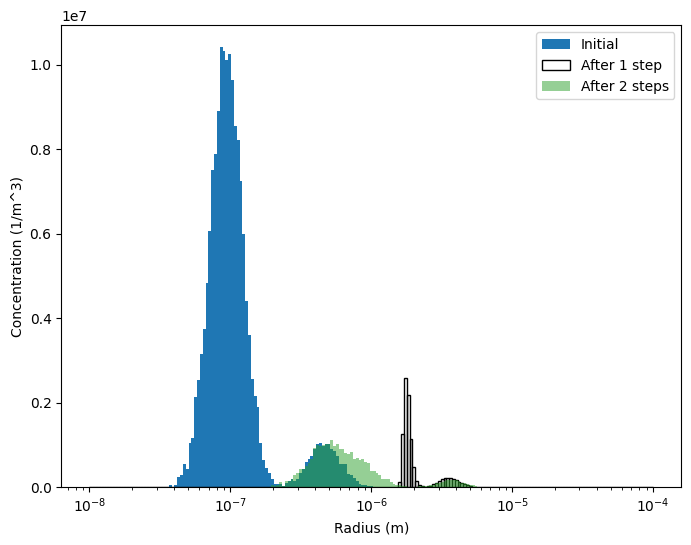

In [109]:
# define the condensation process
condensation_isothermal = CondensationIsothermal(
    molar_mass=np.array([molar_mass_water, molar_mass_ammonium_sulfate]),  # kg/mol
    diffusion_coefficient=2e-6,  # m^2/s
    accommodation_coefficient=0.1,  #makes things go slower/faster
    update_gases=True  # Fixed gas concentration
)
condensation_process = MassCondensation(condensation_strategy=condensation_isothermal)

# define the time array in seconds
time_step = 50
sub_steps = 1000


# output arrays

fig, ax = plt.subplots(figsize=(8, 6))
bins, edges = np.histogram(
    aerosol.particles[0].get_radius(clone=True), bins=bins_lognormal
)

ax.bar(edges[:-1], bins, width=np.diff(edges), align="edge", label="Initial")

# one step
aerosol = condensation_process.execute(aerosol, time_step, sub_steps)
bins, edges = np.histogram(
    aerosol.particles[0].get_radius(clone=True), bins=bins_lognormal
)

ax.bar(edges[:-1], bins, width=np.diff(edges), align="edge", label="After 1 step", edgecolor="black", fill=False)

# 10 seconds
aerosol = condensation_process.execute(aerosol, time_step, sub_steps)
bins, edges = np.histogram(
    aerosol.particles[0].get_radius(clone=True), bins=bins_lognormal
)
ax.bar(edges[:-1], bins, width=np.diff(edges), align="edge", label="After 2 steps", alpha=0.5)


ax.set_xscale("log")
# ax.set_yscale("log")
plt.legend()
ax.set_xlabel("Radius (m)")
ax.set_ylabel("Concentration (1/m^3)")
plt.show()

## Small Particles Grow Faster

We can see from the previous example that the smaller particles grow faster than the larger particles. This is because the smaller particles have a higher surface area to volume ratio, which means they can take up more water.

However, that

## Summary

We built out the condensation process, and the equations that define the process. We also defined the inputs and outputs of the process. Next we will build out coagulation and nucleation processes, to complete the aerosol dynamics framework.